# ImageNet Analyze different methods

This notebook computes -- for a single input image -- saliency maps for a number of networks and methods.
Since we run each combination for one image only, each analysis starts with the compilation of a backward directed computational graph for the respected net and method. In terms of run time efficiency, this is the worst case scenario.

Go grab a coffee after starting this notebook ;)

## Imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imp
import time
import sys
import os
import argparse

import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


# Select models and input image.
A full list of currently available models is available via `innvestigate.applications.imagenet.__all__`.

This analysis is based on a single test image of the ones stored in `examples/images`. Other example images can be used by loading these into the above folder.

In [3]:
# Choose a list of models
netnames = ["vgg16",
            "resnet50",
            "inception_v3",
            "densenet121"]           
n_nets = len(netnames)

# Choose the number of an image in the example folder (between 0-6)
image_n = 3


# Analysis
Now we do the heavy lifting. Note that *after* the computational graph for each method has been computed once, consecutive analysis by reusing the same analyzer object are considerably cheaper, as demonstrated with the example notebooks for [ImageNet](imagenet_example.ipynb) and [MNIST](mnist_example.ipynb).

A message stating *Analyzer not available for this model* may appear, meaning that an analyzer as configured within the `methods` list in below cell can not operate on the given network architecture.  

In [4]:
pattern_type = "relu"
channels_first = keras.backend.image_data_format == "channels_first"
analysis_all = []
text = []


for i, netname in enumerate(netnames):
    print("Analyzing {}...".format(netname))
    
    # Build model.
    tmp = getattr(innvestigate.applications.imagenet, netname)
    net = tmp(load_weights=True, load_patterns=pattern_type)
    model = keras.models.Model(inputs=net["in"], outputs=net["out"])
    model.compile(optimizer="adam", loss="categorical_crossentropy")
    modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
    modelp.compile(optimizer="adam", loss="categorical_crossentropy")
    
    # Load image from example folder
    images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])
    images = images[image_n]
    
    color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None
        
    # Create analyzers.
    patterns = net["patterns"]
    methods = [
        # NAME                      OPT.PARAMS                POSTPROC FXN                TITLE

        # Show input.
        ("input",                   {},                       imgnetutils.image,   "Input"),

        # Function
        ("gradient",                {},                       imgnetutils.graymap, "Gradient"),
        ("integrated_gradients",    {},                       imgnetutils.graymap, "Integrated Gradients"),

        # Signal
        ("deconvnet",               {},                       imgnetutils.bk_proj, "Deconvnet"),
        ("guided_backprop",         {},                       imgnetutils.bk_proj, "Guided Backprop"),
        ("pattern.net",             {"patterns": patterns},   imgnetutils.bk_proj, "PatterNet"),

        # Interaction
        ("pattern.attribution",     {"patterns": patterns},   imgnetutils.heatmap, "Pattern Attribution"),
        ("lrp.epsilon",             {"epsilon": 1},           imgnetutils.heatmap, "LRP Epsilon"),
        ("lrp.sequential_preset_a_flat", {"epsilon": 1},      imgnetutils.heatmap, "LRP-PresetAFlat"),
        ("lrp.sequential_preset_b_flat", {"epsilon": 1},      imgnetutils.heatmap, "LRP-PresetBFlat"),
    ]
    
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],
                                                      model,
                                                      **method[1])
        except innvestigate.NotAnalyzeableModelException:
            analyzer = None
        analyzers.append(analyzer)

    # Create analysis.
    analysis = np.zeros([len(analyzers)] + net["image_shape"] + [3])

    image,y = images
    image = image[None, :, :, :]
    # Predict label.
    x = imgnetutils.preprocess(image, net)
    presm = model.predict_on_batch(x)[0]
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" %label_to_class_name[y],       # ground truth label
                 "%.2f" %presm.max(),                # pre-softmax logits
                 "%.2f" % prob.max(),                # probabilistic softmax output  
                 "%s" %label_to_class_name[y_hat]    # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        if analyzer != None:
            a = analyzer.analyze(image if is_input_analyzer else x)

            # Postprocess.
            if not np.all(np.isfinite(a)):
                print("Image %i, analysis of %s not finite: nan %s inf %s" %
                      (i, methods[aidx][3],
                       np.any(np.isnan(a)), np.any(np.isinf(a))))
            if not is_input_analyzer:
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
            a = methods[aidx][2](a)
            analysis[aidx] = a[0]
        else:
            print("Analyzer not available for this model.")
            analysis[aidx] = np.zeros_like(image)         
    
    # Clear session.
    if keras.backend.backend() == 'tensorflow':
        keras.backend.clear_session()
    
    analysis_all.append(analysis)

Analyzing vgg16...
A local file was found, but it seems to be incomplete or outdated because the sha256 file hash does not match the original value of 847a05e1cb2d689d56170cc1998a2d042d5624c6e58f19ac916b5d70555c41ad0 so we will re-download the data.
553385984/553380098 [==============================] - 23s 0us/step
Analyzing resnet50...
Analyzer not available for this model.
Analyzer not available for this model.
Analyzing inception_v3...
Analyzer not available for this model.
Analyzer not available for this model.
Analyzing densenet121...
Analyzer not available for this model.
Analyzer not available for this model.


## Results
Concludingly, we draw the resulting saliency maps as networks (rows) vs methods (columns) grid.

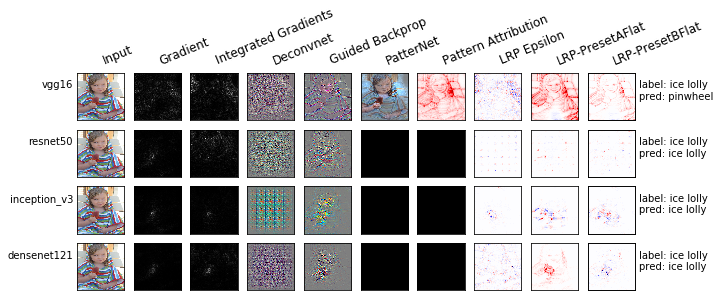

In [5]:
# Plot the analysis.
grid = [[analysis_all[i][j] for j in range(len(methods))]
        for i in range(n_nets)]
label, presm, prob, pred = zip(*text)
row_labels_left = [(n,'') for n in netnames]
row_labels_right = [('label: {}'.format(label[i]),'pred: {}'.format(pred[i])) for i in range(len(label))]
col_labels = [method[3] for method in methods]

eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels)